1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:
import pandas as pd
import numpy as np
import datetime as dt


file_name = 'data/data_000637.txt'
max_line_index = len(open(file_name).readlines())-1
scale = 1
N = max(10000,round(scale*max_line_index))
data = pd.read_csv(file_name, nrows=N)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [3]:
temp = data.copy()
temp['MAX_BX_PER_ORBIT'] = temp.groupby('ORBIT_CNT')['BX_COUNTER'].transform(np.max)
extimated_x = round(np.mean(temp['MAX_BX_PER_ORBIT'].unique()))
print(extimated_x)

2562


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [4]:
def toNs(orb,x,tdc,extimated_x):
    return (orb*extimated_x+x)*30 + tdc*25/30

data['ABSOLUTE_TIME'] = toNs(data['ORBIT_CNT'], data['BX_COUNTER'], data['TDC_MEAS'], extimated_x)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABSOLUTE_TIME
0,1,0,123,3869200167,2374,26,2.973867e+14
1,1,0,124,3869200167,2374,27,2.973867e+14
2,1,0,63,3869200167,2553,28,2.973867e+14
3,1,0,64,3869200167,2558,19,2.973867e+14
4,1,0,64,3869200167,2760,25,2.973867e+14
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,2.973876e+14
1310716,1,1,4,3869211171,763,11,2.973876e+14
1310717,1,0,64,3869211171,764,0,2.973876e+14
1310718,1,0,139,3869211171,769,0,2.973876e+14


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [5]:
max_orbit = data['ORBIT_CNT'].max()
temp = data[data['ORBIT_CNT'] == max_orbit]
x_max = temp['BX_COUNTER'].max()
temp = temp[temp['BX_COUNTER'] == x_max]
TDC_max = temp['TDC_MEAS'].max()


min_orbit = data['ORBIT_CNT'].min()
temp = data[data['ORBIT_CNT'] == min_orbit]
x_min = temp['BX_COUNTER'].min()
temp = temp[temp['BX_COUNTER'] == x_min]
TDC_min = temp['TDC_MEAS'].min()


start = toNs(min_orbit, x_min, TDC_min, extimated_x)
stop = toNs(max_orbit, x_max, TDC_max, extimated_x)

start2 = data['ABSOLUTE_TIME'].min()
stop2 = data['ABSOLUTE_TIME'].max()

print('Total duration HH:MM:SS ', dt.timedelta(seconds=(stop-start)*10**(-9)))

print('Total duration HH:MM:SS ', dt.timedelta(seconds=(stop2-start2)*10**(-9)))

Total duration HH:MM:SS  0:00:00.845719
Total duration HH:MM:SS  0:00:00.845725


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [6]:
temp = data.groupby('TDC_CHANNEL').size().sort_values(ascending=False)
temp.iloc[[0,1,2]]

TDC_CHANNEL
139    108059
64      66020
63      64642
dtype: int64

6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [7]:
count = len(data['ORBIT_CNT'].unique())
print(count)

11001


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [27]:
count = len(data[data['TDC_CHANNEL'] == 139]['ORBIT_CNT'].unique())
print(count)
data

10976


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABSOLUTE_TIME
0,1,0,123,3869200167,2374,26,2.973867e+14
1,1,0,124,3869200167,2374,27,2.973867e+14
2,1,0,63,3869200167,2553,28,2.973867e+14
3,1,0,64,3869200167,2558,19,2.973867e+14
4,1,0,64,3869200167,2760,25,2.973867e+14
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,2.973876e+14
1310716,1,1,4,3869211171,763,11,2.973876e+14
1310717,1,0,64,3869211171,764,0,2.973876e+14
1310718,1,0,139,3869211171,769,0,2.973876e+14


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [97]:
data1 = data.copy()
data1 = data1[data1['FPGA']==0]
FPGA1 = pd.Series(data1.groupby('TDC_CHANNEL').size())
data2 = data.copy()
data2 = data2[data2['FPGA']==1]
FPGA2 = pd.Series(data2.groupby('TDC_CHANNEL').size())
FPGA1,FPGA2

(TDC_CHANNEL
 1       1215
 2       1602
 3       1493
 4       2352
 5       1432
        ...  
 129        2
 130       33
 137       32
 138       34
 139    75617
 Length: 124, dtype: int64,
 TDC_CHANNEL
 1      28438
 2      32669
 3      21970
 4      26403
 5      15003
        ...  
 129       35
 130       38
 137       36
 138       36
 139    32442
 Length: 132, dtype: int64)

9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

<BarContainer object of 132 artists>

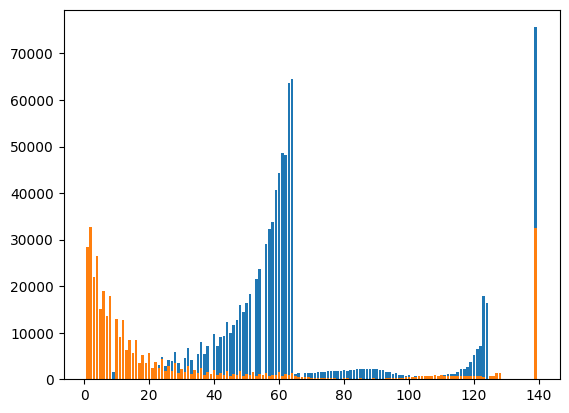

In [119]:
import matplotlib.pyplot as plt


plt.bar(FPGA1.index, FPGA1.values)
plt.bar(FPGA2.index, FPGA2.values)